# Estabilizando rede neurais - Batch Normalization

### Problemas com redes profundas

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn

def conv3x3(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)

class Model(nn.Module):
    '''Modelo com n camadas convolucionais.'''
    def __init__(self, num_layers, features):
        super().__init__()
        
        layers = [
            conv3x3(1,features),
            nn.ReLU()
        ]
        for idx in range(1, num_layers):
            layers.append(conv3x3(features,features))
            layers.append(nn.ReLU())
        self.layers = nn.ModuleList(layers)

        self.pool = nn.AdaptiveMaxPool2d(2)
        # Camada linear que recebe features imagens de tamanho 2x2 e gera 10 valores de saída
        self.fc = nn.Linear(features*2*2, 10)

    def forward(self, x):
        '''Além de calcular o resultado, este método retorna as ativações
        inermediárias da rede.'''
        acts = []
        for layer in self.layers:
            x = layer(x)
            acts.append(x)
        x = self.pool(x)
        # Transformação das imagens de tamanho bs x features x 2 x 2 para bs x features*2*2
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x, acts
    
model = Model(10, 16)
model

Model(
  (layers): ModuleList(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): ReLU()
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): ReLU()
    (8): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): ReLU()
    (10): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): ReLU()
    (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): ReLU()
    (14): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (15): ReLU()
    (16): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (17): ReLU()
    (18): Conv2d(16, 16, kernel_siz

Execute a célula abaixo diversas vezes com ctrl+enter. A saída da rede é sempre a mesma!

In [23]:
x = torch.rand(1, 1, 28, 28)
y, acts = model(x)

print(x[0,0,0])
print(y)

tensor([0.1880, 0.1356, 0.7953, 0.4343, 0.0365, 0.5274, 0.6057, 0.2733, 0.5580,
        0.2604, 0.0525, 0.5954, 0.5802, 0.3762, 0.3247, 0.7492, 0.6043, 0.2902,
        0.0463, 0.8151, 0.2244, 0.0532, 0.1106, 0.7502, 0.6842, 0.9088, 0.1076,
        0.3317])
tensor([[-0.0213,  0.0993, -0.0237,  0.0249,  0.0119,  0.0895,  0.0157, -0.1136,
         -0.0405,  0.0689]], grad_fn=<AddmmBackward0>)


A saída da rede é dada apenas pelo bias da última camada:

In [25]:
print(y)
print(model.fc.bias.detach())

tensor([[-0.0213,  0.0993, -0.0237,  0.0249,  0.0119,  0.0895,  0.0157, -0.1136,
         -0.0405,  0.0689]], grad_fn=<AddmmBackward0>)
tensor([-0.0213,  0.0994, -0.0237,  0.0249,  0.0119,  0.0895,  0.0157, -0.1136,
        -0.0405,  0.0689])


Plotando a média e desvio padrão das ativações intermediárias da rede, vemos que os valores caem para zero:

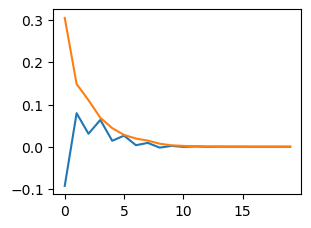

In [4]:
def show_activations(acts):
    act_mean = []
    act_std = []
    for act in acts:
        act = act.detach()
        act_mean.append(act.mean())
        act_std.append(act.std())

    plt.plot(act_mean)
    plt.plot(act_std)

show_activations(acts)

Essencialmente, a operação que uma rede neural faz é dada por:

In [26]:
# Batch de dados
x = torch.rand(10)
# Parâmetros das camadas
weight = 2.
bias = 2.
# 100 camadas
for i in range(100):
    x = (weight*x+bias)
print(x)

tensor([2.9904e+30, 2.8932e+30, 3.3234e+30, 3.4615e+30, 2.5454e+30, 3.1341e+30,
        3.1211e+30, 3.0075e+30, 2.6490e+30, 3.7316e+30])


Tente achar valores de `weight` e `bias` que não levem o valor de x acima a 0, infinito ou algum valor trivial.

### Batch Normalization

Ao normalizarmos os valores, as ativações se tornam bem comportadas!

In [27]:
def normalization(x):
    mean = x.mean()
    std = x.std()
    return (x-mean)/std

x = torch.rand(10)
weight = 20.
bias = -10.
for i in range(10):
    x = (weight*x+bias)
    x = normalization(x)
print(x)

tensor([ 0.3380, -1.1615,  0.6598,  1.6353,  0.2101, -1.1059, -1.1178,  0.7364,
         0.7241, -0.9186])


Mas e se a escala dos valores for relevante para a classificação? Por exemplo, talvez um filtro tenda a gerar valores em torno de 10, enquanto que outro filtro gere valores em torno de 0.1. Essa informação será perdida após a normalização.

Uma camada batchnorm permite reescalar os valores caso seja necessário. Os parâmetros de escala são aprendidos durante o treinamento.

In [28]:
class BatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        # nn.Parameter define um tensor com requires_grad=True e que é registrado 
        # como parâmetro treinável do modelo
        self.gamma = nn.Parameter(torch.tensor(1.))
        self.beta = nn.Parameter(torch.tensor(0.))

        self.eps = 1e-5

    def forward(self, x):

        mean = x.mean()
        var = x.var()   # Variância
        # eps evita divisão por 0
        x_norm = (x-mean)/torch.sqrt(var+self.eps)

        # Reescala os valores
        y = self.gamma*x_norm + self.beta

        return y
    
bn = BatchNorm()
bn(100*torch.rand(10))


tensor([-1.1354,  1.0410,  0.6823,  1.2006, -1.2318,  0.6611,  0.9026, -1.0669,
        -0.8861, -0.1673], grad_fn=<AddBackward0>)

Mas temos um problema. E quando formos aplicar a rede após o treinamento em uma única imagem? Cada camada terá apenas uma única ativação, o que pode ser um problema. Para evitar isso, durante o treinamento podemos armazenar a média e desvio padrão de todos os batches, e usar a estimativa desses parâmetros de todos os batches para normalizar os valores ao aplicar em uma única imagem.

### Desvendando a camada BatchNorm do Pytorch

In [29]:
# Batchnorm aplicado em 3 canais
bn = nn.BatchNorm1d(3)
print(bn.weight)
print(bn.bias)

Parameter containing:
tensor([1., 1., 1.], requires_grad=True)
Parameter containing:
tensor([0., 0., 0.], requires_grad=True)


A longo de vários batches, a camada estima a média e variância dos dados:

In [30]:
for i in range(100):
    # Batches de 4 elementos, 3 canais cada e 6 valores para cada canal
    # Os valores gerados possuem média 4 e variância 9.
    x = torch.normal(mean=4, std=1, size=(4,3,6))
    _ = bn(x)
    print('mean', bn.running_mean)
    #print('var', bn.running_var)



mean tensor([0.3976, 0.3957, 0.3768])
mean tensor([0.8059, 0.7492, 0.7223])
mean tensor([1.1346, 1.0626, 1.0561])
mean tensor([1.4222, 1.3861, 1.3661])
mean tensor([1.6574, 1.6237, 1.6162])
mean tensor([1.9095, 1.8259, 1.8565])
mean tensor([2.1217, 2.0394, 2.0852])
mean tensor([2.3098, 2.2675, 2.2550])
mean tensor([2.4725, 2.4673, 2.3974])
mean tensor([2.6355, 2.6099, 2.5412])
mean tensor([2.7651, 2.7594, 2.7023])
mean tensor([2.8893, 2.8686, 2.8218])
mean tensor([2.9997, 2.9632, 2.9677])
mean tensor([3.1022, 3.0244, 3.0622])
mean tensor([3.2035, 3.0938, 3.1895])
mean tensor([3.2991, 3.1593, 3.3072])
mean tensor([3.3573, 3.3134, 3.3960])
mean tensor([3.4208, 3.3631, 3.4800])
mean tensor([3.4661, 3.4020, 3.5291])
mean tensor([3.5498, 3.4867, 3.5969])
mean tensor([3.6073, 3.5241, 3.6387])
mean tensor([3.6699, 3.5395, 3.6787])
mean tensor([3.6694, 3.5671, 3.7246])
mean tensor([3.6965, 3.6042, 3.7235])
mean tensor([3.7274, 3.6424, 3.7647])
mean tensor([3.7780, 3.6519, 3.7687])
mean tensor(

No modo eval, a média estimada é usada quando a camada for aplicada em novos dados:

In [31]:
# Batch de tamanho 1000 com valores de média 10
# A média do resultado deve ser aproximadamente 10-bn.running_mean
x = torch.normal(mean=10, std=6, size=(1000,3,60))
bn.eval()
y = bn(x)
print(y.mean())

tensor(5.9248, grad_fn=<MeanBackward0>)


Retornando o batchnorm para o modo .train faz com que a camada volte a normalizar pela média e desvio do batch:

In [32]:
x = torch.normal(mean=10, std=6, size=(1000,3,60))
bn.train()
y = bn(x)
print(y.mean())

tensor(-3.6621e-08, grad_fn=<MeanBackward0>)
